# Preliminary operations

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install emoji
!pip install lexrank
!pip install contractions
!pip install sentence-transformers
!pip install 'scipy>=1.8'

In [ ]:
# Utility
from google.colab import drive
import pandas as pd
pd.set_option('display.max_rows', 500)
from shutil import copyfile
from collections import Counter
import csv
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn import metrics
import numpy as np
from scipy import spatial
import time
import random
from operator import itemgetter

# Nltk
from nltk.tokenize import TweetTokenizer, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# String operations
import re
import string
from emoji import demojize
import contractions

# Embedding
import gensim
from gensim.models import Word2Vec, Doc2Vec

# Summarization
from transformers import T5Tokenizer, T5ForConditionalGeneration, BartForConditionalGeneration, BartTokenizer
import sentencepiece
from sentence_transformers import SentenceTransformer
import torch
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
import networkx as nx

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We perform abstractive and extractive summarization. For the abstractive one, we use T5 and BART pre-trained models, while for the extractive we use LexRank and TextRank with three different approaches: TF-IDF, Doc2Vec and BERTweet.

# Summarization - abstractive

We use the following models in order to perform the abstractive summarization: T5, BART.

In [ ]:
df = pd.read_csv('gdrive/My Drive/Text Mining & Search/preprocessed.csv')
df.head()

,Datetime,Text,Username,Likes,Retweets,Hashtags,Mentions
0,2022-12-18 23:57:22+00:00,"despite conceding 3️⃣ goals apiece, &amp; hugo...",JioCinema,58,15,"['FIFAWorldCup', 'ARGFRA', 'Qatar2022', 'FIFAW...","['emimartinezz1', 'Mahindra_Auto']"
1,2022-12-18 23:54:59+00:00,"12/18/2022 - 📍times square, nyc argentina beat...",galassitweets,13,2,"['FIFAWorldCup', 'ArgentinaVsFrance', 'Qatar20...",[]
2,2022-12-18 23:54:52+00:00,"and at 2:52am on monday, december 19, it's a w...",gabetan13,28,0,"['FIFAWorldCup', 'Qatar2022']",[]
3,2022-12-18 23:54:48+00:00,would the question be even asked if it was ano...,farjad99,16,3,['WorldcupQatar2022'],['IlmFeed']
4,2022-12-18 23:53:22+00:00,"""it is a dress for an official occasion, worn ...",ShamoonHafez,920,113,"['Qatar2022', 'FifaWorldCup']",[]


We want to summarize the most important hashtags and those teams that made it to the semifinals (i.e. Morocco, Argentina, Croatia and France). 

First of all, let's have a look at the 40 most popular hashtags.

In [ ]:
hash_df = pd.read_csv('gdrive/My Drive/Text Mining & Search/hashtags.csv')
print(hash_df[:40])

                  Hashtag  Occurrences
0               Qatar2022        74116
1            FIFAWorldCup        40419
2            WorldCup2022        38927
3        FIFAWorldCup2022        14524
4       QatarWorldCup2022        11258
5       WorldcupQatar2022        10163
6                WorldCup        10117
7                 WCQ2022         7399
8                   Qatar         6342
9               Argentina         4169
10                 Messi𓃵         3179
11  FIFAWorldCupQatar2022         3002
12                Morocco         2987
13      ArgentinaVsFrance         2789
14                   FIFA         2440
15                  Messi         2412
16                    ARG         2365
17                    NFT         2077
18          QatarWorldCup         1968
19                 ARGFRA         1957
20               football         1956
21          SayTheirNames         1860
22             BlackStars         1710
23          WorldCupFinal         1708
24                 France

Demojizing for those tokenizers (T5) which do not support emojis.

In [ ]:
df['Text_demojized'] = df['Text'].apply(lambda x: demojize(x, delimiters = (' _', '_ ')).lower())
print(df['Text_demojized'].head())

0    despite conceding  _keycap_3_  goals apiece, &...
1    12/18/2022 -  _round_pushpin_ times square, ny...
2    and at 2:52am on monday, december 19, it's a w...
3    would the question be even asked if it was ano...
4    "it is a dress for an official occasion, worn ...
Name: Text_demojized, dtype: object


In order to take hashtags that are different from each other (avoiding, for example, FIFAWorldCup and WorldCup2022 that are very similar), we choose:
*   Qatar2022, i.e. the most general hashtag regarding the World Cup.
*   SayTheirNames.
*   BoycottQatar2022.
*   Messi𓃵.

In [ ]:
qatar2022 = []
saytheirnames = []
boycottqatar = []
messi = []
argentina = []
france = []
croatia = []
morocco = []
qatar2022_ = []
saytheirnames_ = []
boycottqatar_ = []
messi_ = []
argentina_ = []
france_ = []
croatia_ = []
morocco_ = []

for i in range(len(df)):
  if 'Qatar2022' in df['Hashtags'][i]:
    qatar2022.append(df['Text'][i])
    qatar2022_.append(df['Text_demojized'][i])
  if 'SayTheirNames' in df['Hashtags'][i]:
    saytheirnames.append(df['Text'][i])
    saytheirnames_.append(df['Text_demojized'][i])
  if 'BoycottQatar' in df['Hashtags'][i]:
    boycottqatar.append(df['Text'][i])
    boycottqatar_.append(df['Text_demojized'][i])
  if 'Messi' in df['Hashtags'][i]:
    messi.append(df['Text'][i])
    messi_.append(df['Text_demojized'][i])
  if 'Argentina' in df['Hashtags'][i]:
    argentina.append(df['Text'][i])
    argentina_.append(df['Text_demojized'][i])
  if 'France' in df['Hashtags'][i]:
    france.append(df['Text'][i])
    france_.append(df['Text_demojized'][i])
  if 'Croatia' in df['Hashtags'][i]:
    croatia.append(df['Text'][i])
    croatia_.append(df['Text_demojized'][i])
  if 'Morocco' in df['Hashtags'][i]:
    morocco.append(df['Text'][i])
    morocco_.append(df['Text_demojized'][i])

In [ ]:
hash_list = [qatar2022, saytheirnames, boycottqatar, messi, argentina, france, croatia, morocco]
hash_list_demojized = [qatar2022_, saytheirnames_, boycottqatar_, messi_, argentina_, france_, croatia_, morocco_]

## Exploration

Let's explore the following features for each sub-dataset:
*   Number of tweets.
*   Number of sentences.
*   Average number of sentences for each tweet.
*   Number of words.
*   Average number of words for each tweet.
*   Number of unique words.
*   Ratio between unique words and words.

In [ ]:
# The first hashtag is treated separately so as not to appear in the first graph below
qatar2022 = hash_list_demojized[0]
print('#Qatar2022:')
print('Total number of tweets: ' + str(len(qatar2022)))
# Joining together the tweets by means of dots (many tweets do not end with a dot)
text = '. '.join(''.join(x) for x in qatar2022).strip()
# Those tweets which already ended with a dot shouldn't have a double dot
text = text.replace("..", ".")
sentences = sent_tokenize(text)
print('Total number of sentences: ' + str(len(sentences)))
print('Average number of sentences for each tweet: ' + str(len(sentences)/len(qatar2022)))
words = 0
x = []
for tweet in qatar2022:
  words+=len(tweet.split())
  x.extend(tweet.split())
unique = len(set(x))
print('Total number of words: ' + str(words))
print('Average number of words for each tweet: ' + str(words/len(qatar2022)))
print('Total number of unique words: ' + str(unique))
print('Ratio between unique words and words: ' + str(unique/words))

#Qatar2022:
Total number of tweets: 50112
Total number of sentences: 99474
Average number of sentences for each tweet: 1.9850335249042146
Total number of words: 1244757
Average number of words for each tweet: 24.839499521072796
Total number of unique words: 69578
Ratio between unique words and words: 0.05589685376342531


In [ ]:
n_tweets = []
n_sentences = []
avg_sentences = []
n_words = []
avg_words = []
n_unique = []
avg_unique = []

for hashtag in hash_list_demojized[1:]:
  # Number of tweets
  n_tweets.append(len(hashtag))
  text = '. '.join(''.join(x) for x in hashtag).strip()
  text = text.replace("..", ".")
  # Number of sentences
  sentences = sent_tokenize(text)
  n_sentences.append(len(sentences))
  # Average sentences for each tweet
  avg_sentences.append(len(sentences)/len(hashtag))
  words = 0
  x = []
  for tweet in hashtag:
    # Number of words
    words+=len(tweet.split())
    x.extend(tweet.split())
  # Number of unique words
  n_unique.append(len(set(x)))
  # Ratio between unique words and words
  avg_unique.append(len(set(x))/words)
  n_words.append(words)
  # Average words for each tweet
  avg_words.append(words/len(hashtag))

for i in range(0, 7):
  print(str(i) + ':')
  print('Total number of tweets: ' + str(n_tweets[i]))
  print('Total number of sentences: ' + str(n_sentences[i]))
  print('Average number of sentences for each tweet: ' + str(avg_sentences[i]))
  print('Total number of words: ' + str(n_words[i]))
  print('Average number of words for each tweet: ' + str(avg_words[i]))
  print('Total number of unique words: ' + str(n_unique[i]))
  print('Ratio between unique words and words: ' + str(avg_unique[i]))
  print('\n')

0:
Total number of tweets: 1567
Total number of sentences: 3245
Average number of sentences for each tweet: 2.070835992342055
Total number of words: 50751
Average number of words for each tweet: 32.3873643905552
Total number of unique words: 5140
Ratio between unique words and words: 0.10127879253610766


1:
Total number of tweets: 779
Total number of sentences: 1562
Average number of sentences for each tweet: 2.005134788189987
Total number of words: 20942
Average number of words for each tweet: 26.883183568677794
Total number of unique words: 5183
Ratio between unique words and words: 0.24749307611498425


2:
Total number of tweets: 2556
Total number of sentences: 5179
Average number of sentences for each tweet: 2.026212832550861
Total number of words: 59633
Average number of words for each tweet: 23.330594679186227
Total number of unique words: 8612
Ratio between unique words and words: 0.14441668203846864


3:
Total number of tweets: 3392
Total number of sentences: 6876
Average numb

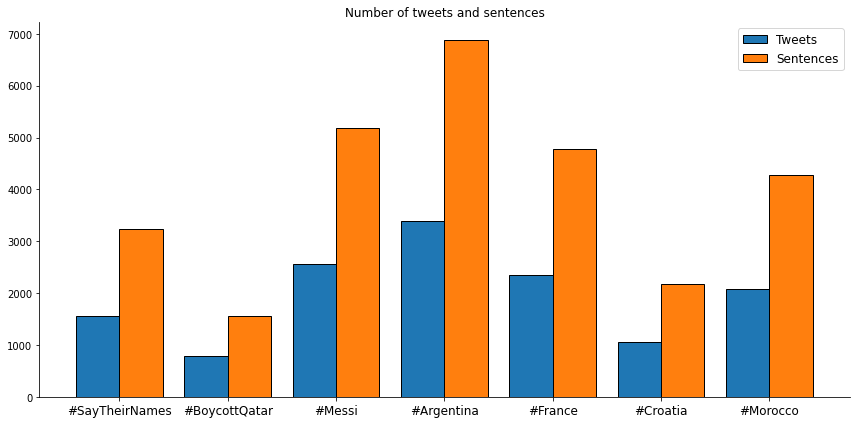

In [ ]:
X = ['#SayTheirNames', '#BoycottQatar', '#Messi', '#Argentina', '#France', '#Croatia', '#Morocco']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis, n_tweets, 0.4, label = 'Tweets', edgecolor = 'black')
plt.bar(X_axis + 0.4, n_sentences, 0.4, label = 'Sentences', edgecolor = 'black')
  
plt.xticks(X_axis + 0.2, X, fontsize = 'large')
plt.title("Number of tweets and sentences")
plt.rcParams["figure.figsize"] = (12, 6)
plt.legend(fontsize = 'large')
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.tight_layout()
plt.savefig('basic_1.png', dpi = 300)
plt.show()

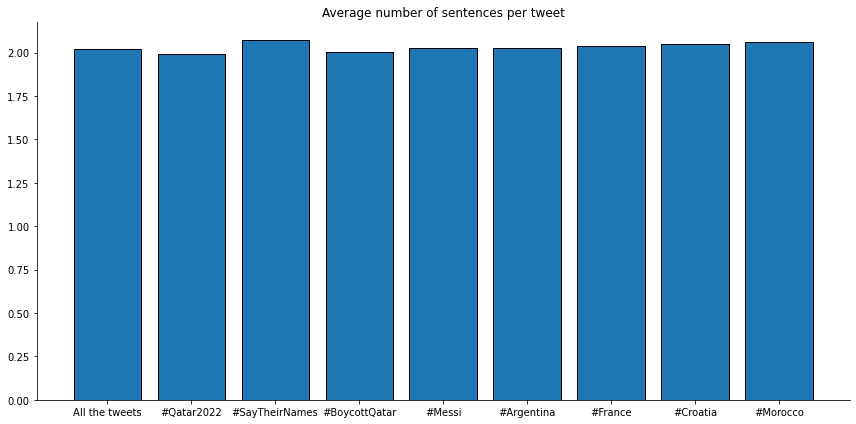

In [ ]:
X = ['All the tweets', '#Qatar2022', '#SayTheirNames', '#BoycottQatar', '#Messi', '#Argentina', '#France', '#Croatia', '#Morocco']

avg_sentences.insert(0, 1.99) # Qatar2022
avg_sentences.insert(0, 2.02) # All the tweets

X_axis = np.arange(len(X))

plt.bar(X_axis, avg_sentences, edgecolor = 'black')

plt.xticks(X_axis, X)
plt.title("Average number of sentences per tweet")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.tight_layout()
plt.savefig('basic_2.png', dpi = 300)
plt.show()

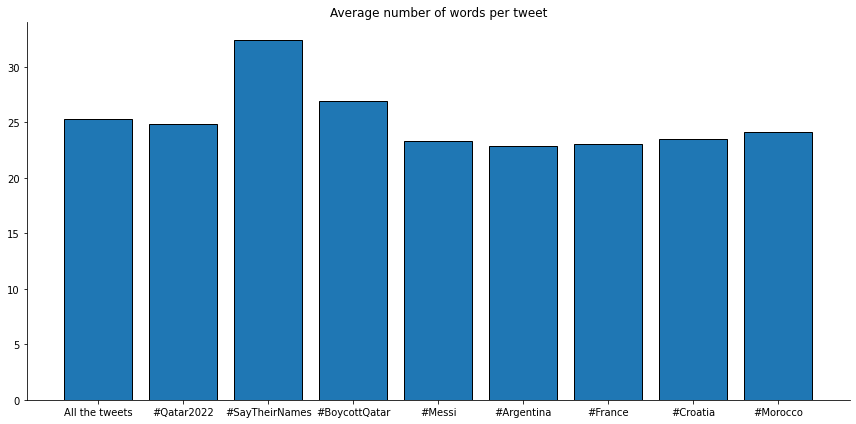

In [ ]:
X = ['All the tweets', '#Qatar2022', '#SayTheirNames', '#BoycottQatar', '#Messi', '#Argentina', '#France', '#Croatia', '#Morocco']
  
avg_words.insert(0, 24.84) # Qatar2022
avg_words.insert(0, 25.3)  # All the tweets

X_axis = np.arange(len(X))

plt.bar(X_axis, avg_words, edgecolor = 'black')

plt.xticks(X_axis, X)
plt.title("Average number of words per tweet")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.tight_layout()
plt.savefig('basic_3.png', dpi = 300)
plt.show()

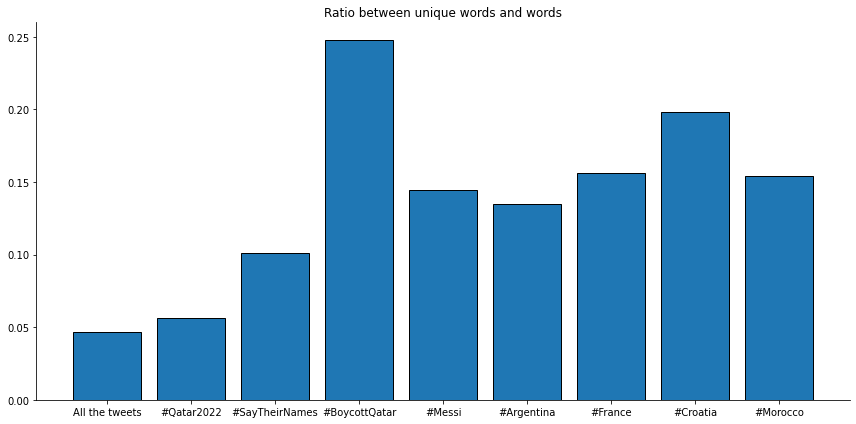

In [ ]:
X = ['All the tweets', '#Qatar2022', '#SayTheirNames', '#BoycottQatar', '#Messi', '#Argentina', '#France', '#Croatia', '#Morocco']

avg_unique.insert(0, 0.056) # Qatar2022
avg_unique.insert(0, 0.047) # All the tweets

X_axis = np.arange(len(X))

plt.bar(X_axis, avg_unique, edgecolor = 'black')

plt.xticks(X_axis, X)
plt.title("Ratio between unique words and words")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/Text Mining & Search/basic_4.png', dpi = 300)
plt.show()

## T5

https://huggingface.co/docs/transformers/model_doc/t5#:~:text=T5%20is%20an%20encoder%2Ddecoder,text%2Dto%2Dtext%20format

In [ ]:
model_t5 = T5ForConditionalGeneration.from_pretrained('t5-large')
tokenizer_t5 = T5Tokenizer.from_pretrained('t5-large', model_max_length = 1024)

In [ ]:
st = time.time()

for i in range(len(hash_list_demojized)):
  # Joining together the tweets by means of dots (many tweets do not end with a dot)
  text = '. '.join(''.join(l) for l in hash_list_demojized[i]).strip()
  # Those tweets which already ended with a dot shouldn't have a double dot
  text = text.replace("..", ".")
  text = "summarize: " + text

  tokens_input = tokenizer_t5.encode(text, return_tensors = "pt", max_length = 1024, truncation = True)
  summary_ids = model_t5.generate(tokens_input, max_new_tokens = 180)

  summary = tokenizer_t5.decode(summary_ids[0], skip_special_tokens = True)
  print(str(i) + ': ' + summary + '\n')

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

0: argentina beat france 1-0 in the world cup final in rio de janeiro. lionel scaloni wore the same shirt he wore in the 1997 world cup final. qatar 2022 is the biggest footballing nation in the world. argentina will be represented by the 'pirate flag' of qatar.

1: iranians are celebrating islamic republic national team's loss against the united states. iranians are celebrating elimination of islamic republic from world cup. iranians are celebrating the death of children killed by the islamic regime.

2: i've boycotted the whole men's world cup in as more than 6.500 workers died. i'm not watching the final today as i'm going to watch the documentary. i'm not sure i'm going to watch the final but i'm going to watch the documentary.

3: argentina beat france 4-2 on penalties to win their third world cup. lionel messi was the _goat_ who won the _world_cup_ in 1986. argentina will travel on an open bus on a victory parade through lusail boulevard. argentina will play england in the final 

## BART

https://huggingface.co/transformers/v3.1.0/model_doc/bart.html

In [ ]:
model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn', model_max_length = 1024)

In [ ]:
st = time.time()

for i in range(len(hash_list)):
  # Joining together the tweets by means of dots (many tweets do not end with a dot)
  text = '. '.join(''.join(l) for l in hash_list[i]).strip()
  # Those tweets which already ended with a dot shouldn't have a double dot
  text = text.replace("..", ".")

  tokens_input = tokenizer_bart.encode(text, return_tensors = 'pt', max_length = 1024, truncation = True)
  summary_ids = model_bart.generate(tokens_input, max_new_tokens = 180)

  summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens = True)
  print(str(i) + ': ' + summary + '\n')

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

0: Argentina beat France 2-0 on penalties to win the 2022 fifa world cup in Qatar. Lionel Scaloni celebrated the win in the same shirt he wore when he won the u-20 world Cup in 1997. "It is a dress for an official occasion, worn for celebrations. this was a celebration of messi," ceo hassan al thawadi said.

1: Ilyas: "Shameless" falls short to explain your behavior! up to 5% of iran consists of people and yet they make for 30% of hanged prisoners in ❗️ while we celebrate the irans losing against usa, you should.. not so fast, even before you meet. he got murdered last night by security forces of islamic regime in iran. why? simply because he was happy that islamIC regime football team lost a game to usa and got eliminated from, and honk his car horn. i wish he would've cried like this for all the children who were murdered by islamics regime. i cannot watch soccer while kids are being raped and murdered.

2: More than 6.500 workers died building the stadiums people are now cheering fr

# Summarization - extractive

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Text Mining & Search/preprocessed.csv')
df.head()

,Datetime,Text,Username,Likes,Retweets,Hashtags,Mentions
0,2022-12-18 23:57:22+00:00,"despite conceding 3️⃣ goals apiece, &amp; hugo...",JioCinema,58,15,"['FIFAWorldCup', 'ARGFRA', 'Qatar2022', 'FIFAW...","['emimartinezz1', 'Mahindra_Auto']"
1,2022-12-18 23:54:59+00:00,"12/18/2022 - 📍times square, nyc argentina beat...",galassitweets,13,2,"['FIFAWorldCup', 'ArgentinaVsFrance', 'Qatar20...",[]
2,2022-12-18 23:54:52+00:00,"and at 2:52am on monday, december 19, it's a w...",gabetan13,28,0,"['FIFAWorldCup', 'Qatar2022']",[]
3,2022-12-18 23:54:48+00:00,would the question be even asked if it was ano...,farjad99,16,3,['WorldcupQatar2022'],['IlmFeed']
4,2022-12-18 23:53:22+00:00,"""it is a dress for an official occasion, worn ...",ShamoonHafez,920,113,"['Qatar2022', 'FifaWorldCup']",[]


We want to summarize the most important hashtags and those teams that made it to the semifinals (i.e. Morocco, Argentina, Croatia and France). 

First of all, let's have a look at the 40 most popular hashtags.

In [ ]:
hash_df = pd.read_csv('/content/gdrive/MyDrive/Text Mining & Search/hashtags.csv')
print(hash_df[:40])

                  Hashtag  Occurrences
0               Qatar2022        74116
1            FIFAWorldCup        40419
2            WorldCup2022        38927
3        FIFAWorldCup2022        14524
4       QatarWorldCup2022        11258
5       WorldcupQatar2022        10163
6                WorldCup        10117
7                 WCQ2022         7399
8                   Qatar         6342
9               Argentina         4169
10                 Messi𓃵         3179
11  FIFAWorldCupQatar2022         3002
12                Morocco         2987
13      ArgentinaVsFrance         2789
14                   FIFA         2440
15                  Messi         2412
16                    ARG         2365
17                    NFT         2077
18          QatarWorldCup         1968
19                 ARGFRA         1957
20               football         1956
21          SayTheirNames         1860
22             BlackStars         1710
23          WorldCupFinal         1708
24                 France

In [ ]:
df['Text_demojized'] = df['Text'].apply(lambda x: demojize(x, delimiters = (' _', '_ ')).lower())
print(df['Text_demojized'].head())

0    despite conceding  _keycap_3_  goals apiece, &...
1    12/18/2022 -  _round_pushpin_ times square, ny...
2    and at 2:52am on monday, december 19, it's a w...
3    would the question be even asked if it was ano...
4    "it is a dress for an official occasion, worn ...
Name: Text_demojized, dtype: object


In order to take hashtags that are different from each other (avoiding, for example, FIFAWorldCup and WorldCup2022 that are very similar), we choose:
*   Qatar2022, i.e. the most general hashtag regarding the World Cup.
*   SayTheirNames.
*   BoycottQatar2022.
*   Messi𓃵.

In [ ]:
qatar2022 = []
saytheirnames = []
boycottqatar = []
messi = []
argentina = []
france = []
croatia = []
morocco = []
qatar2022_ = []
saytheirnames_ = []
boycottqatar_ = []
messi_ = []
argentina_ = []
france_ = []
croatia_ = []
morocco_ = []

for i in range(len(df)):
  if 'Qatar2022' in df['Hashtags'][i]:
    if(df['Likes'][i] >= 500):
      qatar2022.append(df['Text'][i])
      qatar2022_.append(df['Text_demojized'][i])
  if 'SayTheirNames' in df['Hashtags'][i]:
    saytheirnames.append(df['Text'][i])
    saytheirnames_.append(df['Text_demojized'][i])
  if 'BoycottQatar' in df['Hashtags'][i]:
    boycottqatar.append(df['Text'][i])
    boycottqatar_.append(df['Text_demojized'][i])
  if 'Messi' in df['Hashtags'][i]:
    messi.append(df['Text'][i])
    messi_.append(df['Text_demojized'][i])
  if 'Argentina' in df['Hashtags'][i]:
    argentina.append(df['Text'][i])
    argentina_.append(df['Text_demojized'][i])
  if 'France' in df['Hashtags'][i]:
    france.append(df['Text'][i])
    france_.append(df['Text_demojized'][i])
  if 'Croatia' in df['Hashtags'][i]:
    croatia.append(df['Text'][i])
    croatia_.append(df['Text_demojized'][i])
  if 'Morocco' in df['Hashtags'][i]:
    morocco.append(df['Text'][i])
    morocco_.append(df['Text_demojized'][i])

In [ ]:
hash_list = [qatar2022, saytheirnames, boycottqatar, messi, argentina, france, croatia, morocco]
hash_list_demojized = [qatar2022_, saytheirnames_, boycottqatar_, messi_, argentina_, france_, croatia_, morocco_]

## Lex Rank

https://github.com/crabcamp/lexrank

0:
who will face argentina in the world cup final?  _morocco_   _trophy_   _france_ 
unveils fifa world cup 2022 trophy  _argentina_   _vs_button_   _france_  on &amp;
for 44 years 4 penalties were never given in favor of the same team in a world cup until argentina today
genocide by islamic regime on the day when the football match between iran and england is played in the world cup.


Mean scores for hashtag 0: 3.467050920259009
1:
mohsen mohammadpour,17 years old football fan was shot in head by the islamic regime of iran security forces. in the last two months, the islamic regime of iran has deliberately killed more than 60 children.
while the world is watching football, iranian children are being murdered by the islamic terrorist regime in iran. this is . she also loved football. sarina was killed when she was only 16 years old!
sarina esamealzadeh,16 years old football fan was killed by the islamic regime of iran security forces by baton blows on her head. in the last two months,

<Figure size 432x288 with 0 Axes>

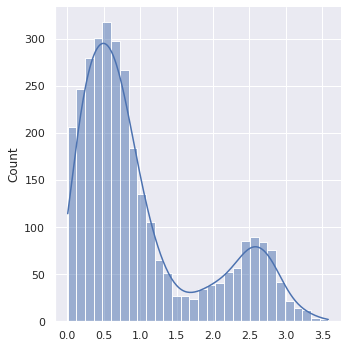

<Figure size 432x288 with 0 Axes>

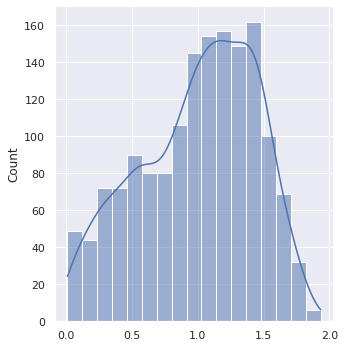

<Figure size 432x288 with 0 Axes>

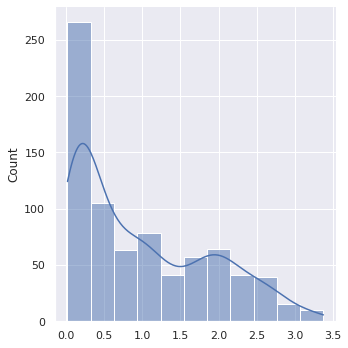

<Figure size 432x288 with 0 Axes>

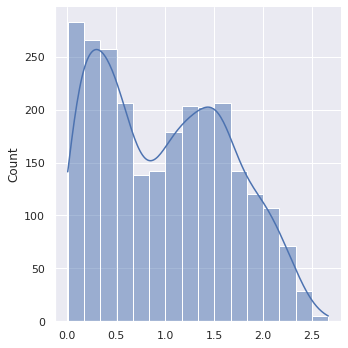

<Figure size 432x288 with 0 Axes>

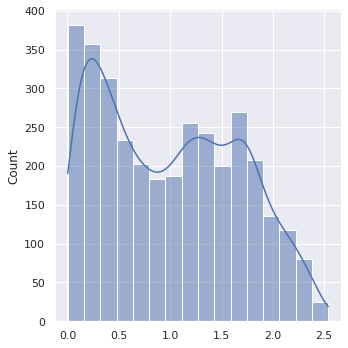

<Figure size 432x288 with 0 Axes>

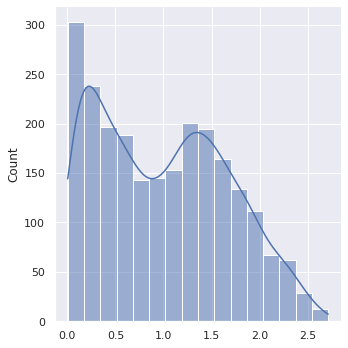

<Figure size 432x288 with 0 Axes>

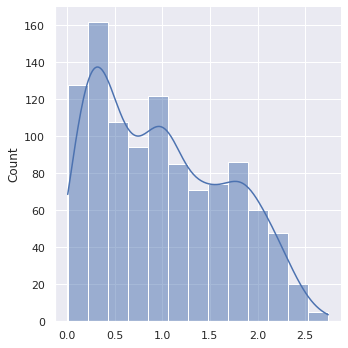

<Figure size 432x288 with 0 Axes>

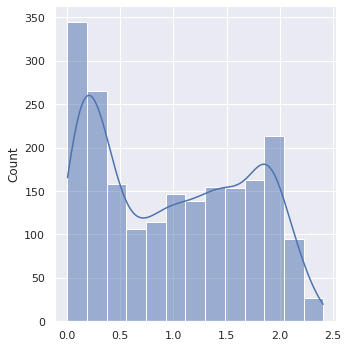

In [ ]:
st = time.time()

for i in range(len(hash_list_demojized)):
  lxr = LexRank(hash_list_demojized[i], stopwords = STOPWORDS['en'])
  summary = lxr.get_summary(hash_list_demojized[i], summary_size = 4, threshold = 0.1)
  print(str(i) + ':' )
  for j in summary:
    print(j)
  print('\n')

  scores = lxr.rank_sentences(
    hash_list_demojized[i],
    threshold = 0.1,
    fast_power_method = False
  )
  plt.figure()
  sns.set(color_codes = True)
  sns.displot(scores, kde = True)
  
  # Order results and print the mean between top-4 scores
  res = scores.tolist()
  res.sort(reverse = True)
  print('Mean scores for hashtag ' + str(i) + ': ' + str(np.mean(res[:4])))
et = time.time()

print('Execution time: ', str(et - st), 'seconds')

## Text Rank

https://medium.com/data-science-in-your-pocket/text-summarization-using-textrank-in-nlp-4bce52c5b390

### TF-IDF

First of all, we apply some preprocessing techniques.

In [ ]:
def remove_punctuation(text, punct):
  punctuation_free = ''.join([i for i in text if i not in punct])
  return punctuation_free

def remove_custom(text):
  # We substitute the "'" and '-' with a white space
  custom = re.sub("(')|(-)", ' ', text)
  return custom

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def tokenize_tweets(text):
  return tokenizer.tokenize(text)

def lemmatize_tweets(text):
  return [(lemmatizer.lemmatize(w)) for w in tokenize_tweets((text))]

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'q', 'r', 'u', 's',
                  'w', 'z', 'amp', 'ha', 'le', 'u', 'wa', 'doe', '_', '_keycap_', '__', '_fire_',
                  '&amp', '_keycap__', 'keycap', 'im', 'ah', 'wa', '&', '_soccer_ball_'])

In [ ]:
def preprocess(text):
  
  # Removing numbers
  text = text.apply(lambda x: re.sub(r'\d+', '', x))
  # Fixing contractions, e.g. you're -> you are
  text = text.apply(lambda x: contractions.fix(x))

  # Remove punctuation
  custom = list(string.punctuation)
  custom.extend(['€', '‘', '–', '’', '|', '\\', '⏱', '↯', ' ⃣0⃣ ', ' ⃣', '↓',
                 '•', '“', '”', '…', "'⃣", '◘'])
  custom.remove("'")
  custom.remove('-')
  # We keep the '_' symbol because it's the delimeter for the emojis
  custom.remove('_')

  text = text.apply(lambda x: remove_punctuation(x, custom))
  text = text.apply(lambda x: remove_custom(x))

  return text

In [ ]:
text_prep = [[]] * len(hash_list_demojized)
for i in range(0, len(hash_list_demojized)):
  text_df = pd.DataFrame(list(hash_list_demojized[i]))
  text_df.rename(columns = {0: 'Text'}, inplace = True)
  # Call preprocess method for each subset
  text_prep[i] = preprocess(text_df['Text'])

0:
lionel andrés messi scores 7 goals in this world cup, 2 goals in the final and 13 total career goals in world cups.  _trophy_  _argentina_ 
the first player to score in the group stage, round of 16, quarter-final, semi-final and final in a single edition of the world cup. lionel messi _goat_ 
 _fire_ the fifa world cup qatar 2022 semifinals are set  _argentina_  argentina vs. croatia  _croatia_   _france_  france vs. morocco  _morocco_   _trophy_  who goes through to the final?
who else?!  _goat_  lionel messi scores argentina's first goal at the world cup!  _argentina_  _sparkles_ 


Mean scores for hashtag 0: 0.0008450334795776789
1:
mohsen mohammadpour,17 years old football fan was shot in head by the islamic regime of iran security forces. in the last two months, the islamic regime of iran has deliberately killed more than 60 children.
while the world is watching football, iranian children are being murdered by the islamic terrorist regime in iran. this is . she also loved footb

<Figure size 432x288 with 0 Axes>

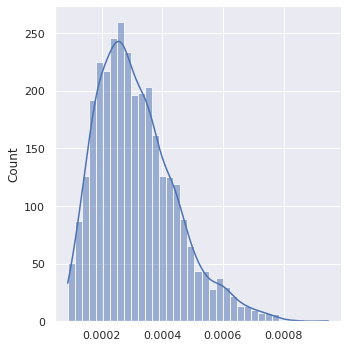

<Figure size 432x288 with 0 Axes>

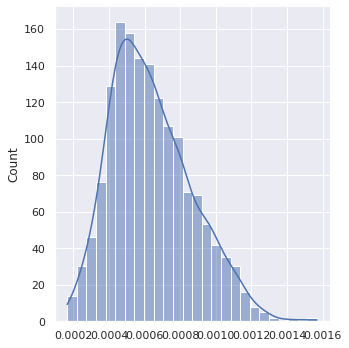

<Figure size 432x288 with 0 Axes>

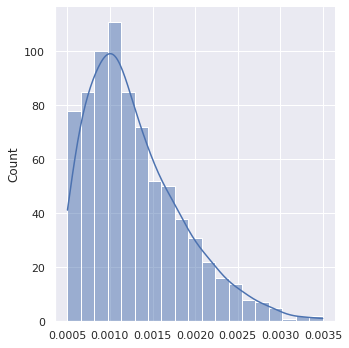

<Figure size 432x288 with 0 Axes>

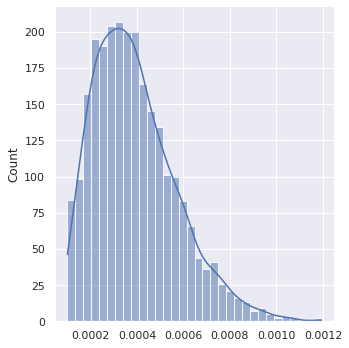

<Figure size 432x288 with 0 Axes>

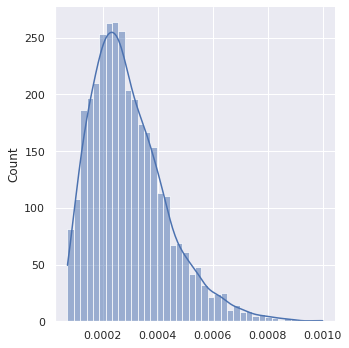

<Figure size 432x288 with 0 Axes>

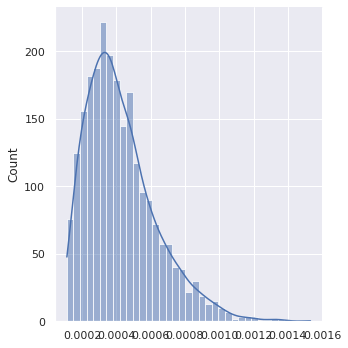

<Figure size 432x288 with 0 Axes>

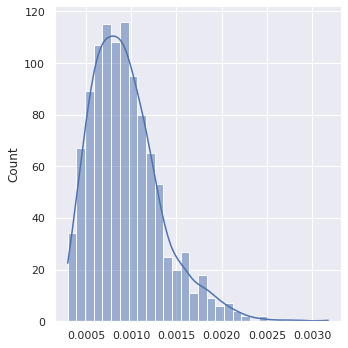

<Figure size 432x288 with 0 Axes>

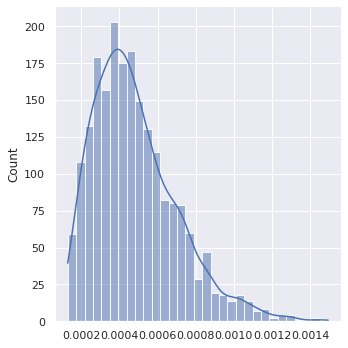

In [ ]:
st = time.time()

for k in range(len(hash_list_demojized)):
  # Compute tf-idf scores 
  tfidf_vectorizer = TfidfVectorizer(tokenizer = lemmatize_tweets, stop_words = stopwords)
  tfidf_matrix = tfidf_vectorizer.fit_transform(text_prep[k])

  # Compute the similarity between tweets
  similarity_matrix_cosine = cosine_similarity(tfidf_matrix)

  # Build the graph of tweets
  graph = np.zeros((len(hash_list_demojized[k]), len(hash_list_demojized[k])))
  for i in range(len(hash_list_demojized[k])):
    for j in range(len(hash_list_demojized[k])):
      graph[i][j] = similarity_matrix_cosine[i][j]
  nx_graph_tfidf = nx.from_numpy_array(graph)
  try:
    # Apply pagerank and save scores
    scores_tfidf = nx.pagerank(nx_graph_tfidf, max_iter = 1000)
    # Take top-4 scores (i.e. top-4 tweets)
    top_sentence_tfidf = {sentence:scores_tfidf[index] for index, sentence in enumerate(hash_list_demojized[k])}
    top_tfidf = dict(sorted(top_sentence_tfidf.items(), key = lambda x: x[1], reverse = True)[:4])
    print(str(k) + ':' )
    for sent in top_sentence_tfidf:
      if sent in top_tfidf.keys():
        print(sent)
    print('\n')
    
    plt.figure()
    sns.set(color_codes = True)
    x = list(scores_tfidf.values())
    sns.displot(x, kde = True)

    # Order results and print the mean between top-4 scores
    res = list(scores_tfidf.values())
    res.sort(reverse = True)
    print('Mean scores for hashtag ' + str(k) + ': ' + str(np.mean(res[:4])))
  except:
    print(str(k) + ': not converged in 1000 iterations')

et = time.time()

print('Execution time: ', str(et - st), 'seconds')

### Doc2Vec

https://radimrehurek.com/gensim/models/doc2vec.html

First of all, we apply some preprocessing techniques.

In [ ]:
def remove_punctuation(text, punct):
  punctuation_free = ''.join([i for i in text if i not in punct])
  return punctuation_free

def remove_custom(text):
  # We substitute the "'" and '-' with a white space
  custom = re.sub("(')|(-)", ' ', text)
  return custom

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def tokenize_tweets(text):
  return tokenizer.tokenize(text)

def lemmatize_tweets(text):
  return [(lemmatizer.lemmatize(w)) for w in tokenize_tweets((text))]

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'q', 'r', 'u', 's',
                  'w', 'z', 'amp', 'ha', 'le', 'u', 'wa', 'doe', '_', '_keycap_', '__', '_fire_',
                  '&amp', '_keycap__', 'keycap', 'im', 'ah', 'wa', '&', '_soccer_ball_'])

In [ ]:
def preprocess(text):
  
  # Removing numbers
  text = text.apply(lambda x: re.sub(r'\d+', '', x))
  # Fixing contractions, e.g. you're -> you are
  text = text.apply(lambda x: contractions.fix(x))

  # Remove punctuation
  custom = list(string.punctuation)
  custom.extend(['€', '‘', '–', '’', '|', '\\', '⏱', '↯', ' ⃣0⃣ ', ' ⃣', '↓',
                '•', '“', '”', '…', "'⃣", '◘'])
  custom.remove("'")
  custom.remove('-')
  # We keep the '_' symbol because it's the delimeter for the emojis
  custom.remove('_')

  text = text.apply(lambda x: remove_punctuation(x, custom))
  text = text.apply(lambda x: remove_custom(x))

  text = text.apply(lambda x: lemmatize_tweets(x))
  text = text.apply(lambda x: [item for item in x if item not in stopwords])

  return text

In [ ]:
text_prep = [[]] * len(hash_list_demojized)
for i in range(0, len(hash_list_demojized)):
  text_df = pd.DataFrame(list(hash_list_demojized[i]))
  text_df.rename(columns = {0: 'Text'}, inplace = True)
  # Call preprocess method for each subset
  text_prep[i] = preprocess(text_df['Text'])

0:
 _teacup_without_handle_ join the testnet trading competition for free, 2,000 $usdc up for grabs!  _grinning_face_ we try to add more fun to the  _soccer_ball_  enter _backhand_index_pointing_down_   _alarm_clock_ time: apply: dec 1 - 3 utc competition: dec 4 - 19 utc  _gem_stone_ rules fill in the form &amp; finish the tasks _fire_ 
while you're watching the match, people in shiraz try to gather to pay tribute to amin bazregar 40 days after his death.he is a grecoroman wrestler,he went missing after his support of navid afkari, his bones found after months in the mountain.
amin bazrgar, a wrestler, went missing after his support for his executed friend, navid afkari, in july 2020. he informed his friends about the regime threatening him. in oct 2022, his bones were found in the mountains of shiraz.
why should indian muslims &amp; arab kuwait and other middle east islamic state hates hindus &amp; zakir naik talking same things about &amp; aisha then why are you against hindus india 

<Figure size 432x288 with 0 Axes>

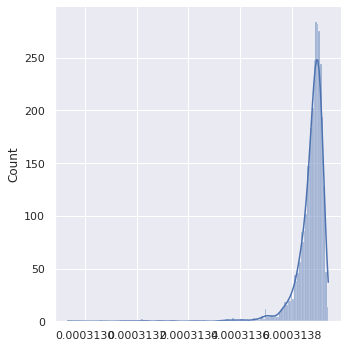

<Figure size 432x288 with 0 Axes>

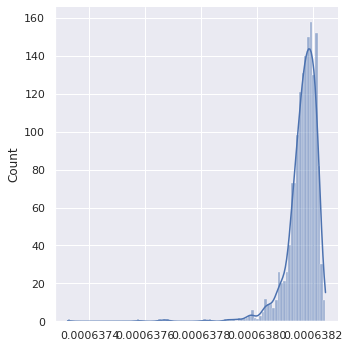

<Figure size 432x288 with 0 Axes>

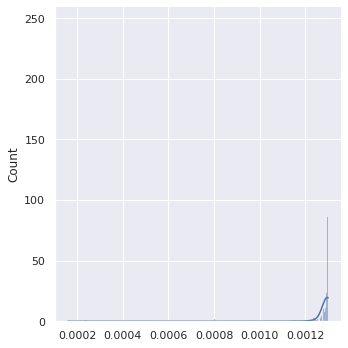

<Figure size 432x288 with 0 Axes>

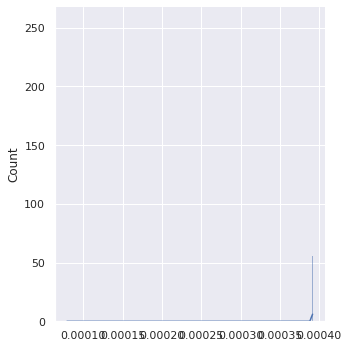

<Figure size 432x288 with 0 Axes>

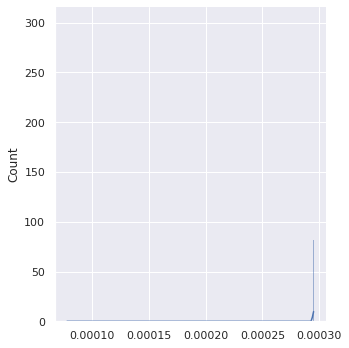

<Figure size 432x288 with 0 Axes>

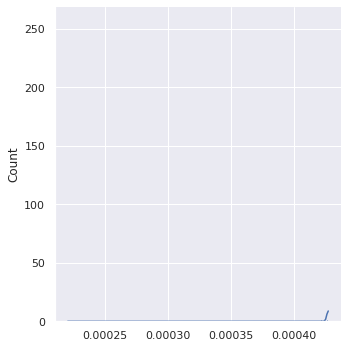

<Figure size 432x288 with 0 Axes>

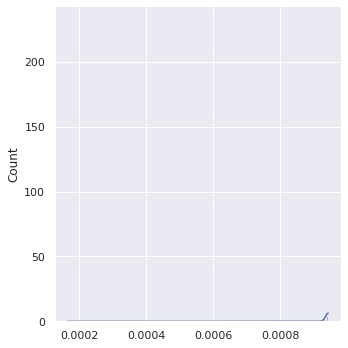

<Figure size 432x288 with 0 Axes>

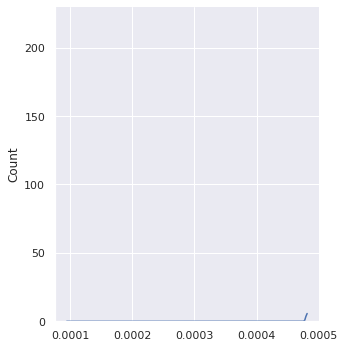

In [ ]:
st = time.time()

for k in range(len(hash_list_demojized)):
  # Compute d2v embedding
  LabeledSentences = gensim.models.doc2vec.TaggedDocument
  all_content = []
  j = 0
  for el in text_prep[k]:
    all_content.append(LabeledSentences(el, [j]))
    j+=1
  model = Doc2Vec(all_content,
                  dm = 0, 
                  vector_size = 256, 
                  window = 2,
                  epochs = 20,
                  seed = 0,
                  hs = 0)
  doc2vec_embedding = model.docvecs.vectors_docs
  
  # Compute the similarity between tweets
  similarity_matrix_cosine = cosine_similarity(doc2vec_embedding)

  # Build the graph of tweets
  graph = np.zeros((len(hash_list_demojized[k]), len(hash_list_demojized[k])))
  for i in range(len(hash_list_demojized[k])):
    for j in range(len(hash_list_demojized[k])):
      graph[i][j] = similarity_matrix_cosine[i][j]
  nx_graph_doc2vec = nx.from_numpy_array(graph)

  try:
    # Apply pagerank and save scores
    scores_doc2vec = nx.pagerank(nx_graph_doc2vec, max_iter = 1000)
    # Take top-4 scores (i.e. top-4 tweets)
    top_sentence_doc2vec = {sentence:scores_doc2vec[index] for index, sentence in enumerate(hash_list_demojized[k])}
    top_doc2vec = dict(sorted(top_sentence_doc2vec.items(), key = lambda x: x[1], reverse = True)[:4])
    print(str(k) + ':' )
    for sent in top_sentence_doc2vec:
      if sent in top_doc2vec.keys():
        print(sent)
    print('\n')
    
    plt.figure()
    sns.set(color_codes = True)
    x = list(scores_doc2vec.values())
    sns.displot(x, kde = True)
    
    # Order results and print the mean between top-4 scores
    res = list(scores_doc2vec.values())
    res.sort(reverse = True)
    print('Mean scores for hashtag ' + str(k) + ': ' + str(np.mean(res[:4])))
  except:
    print(str(k) + ': not converged in 1000 iterations')

et = time.time()

print('Execution time: ', str(et - st), 'seconds')

Doc2Vec seems not very suitable for this job, for many reasons:
*   Both D2V and PageRank are computationally intensive algorithms.
*   Both D2V and PageRank are unsupervised methods and this negatively affects the quality of the summary.
*   Most importantly, both TextRank and Doc2Vec require large amount of data for better performances.


### BERTweet

https://huggingface.co/r2d2/stsb-bertweet-base-v0

0:
a match worthy of a final. what a superb game argentina 🇦🇷 and france 🇫🇷, it was a real treat for all football fans. congratulations to argentina and all the admirers of . well played . truly a special and skilful player.
from space to the football pitch. we brought the official football for fifa world cup qatar™️, becoming part of this historical out of the world journey together with and .
🗺️ team of the week it's now time to unveil our highest-rated xi from the quarterfinal! 👇 croatia lead the way with four players featured in here following their excellent outing against brazil, while lionel messi is our player of the week. 🇦🇷🌟
🚀gospace special quarter-finals winner prediction -9 december 👑 🇧🇷 vs 🇭🇷 🇳🇱 vs 🇦🇷 root for your favourite team and share a 1m go coins prize pool with ⚽️soccer lovers at


Mean scores for hashtag 0: 0.0004561163389101071
1:
mohsen mohamadpoor was a big fan of (an iranian football team) he was brutally killed due to police forces during the 2019 protests k

<Figure size 432x288 with 0 Axes>

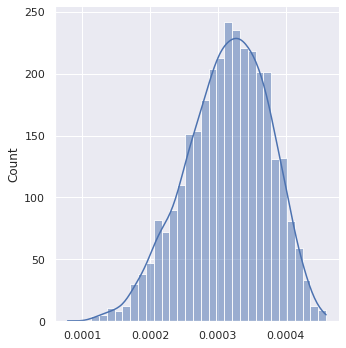

<Figure size 432x288 with 0 Axes>

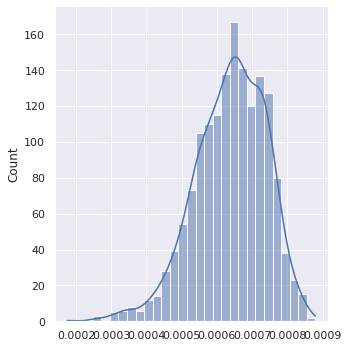

<Figure size 432x288 with 0 Axes>

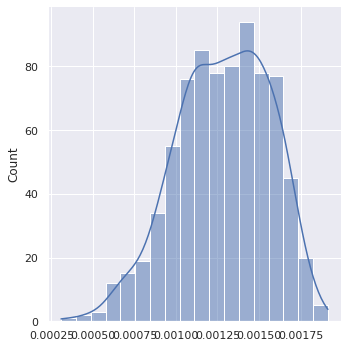

<Figure size 432x288 with 0 Axes>

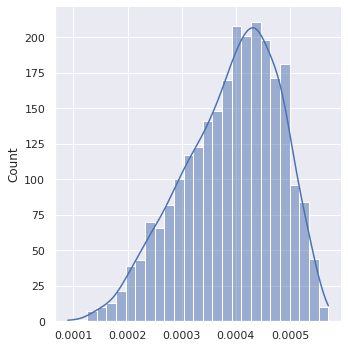

<Figure size 432x288 with 0 Axes>

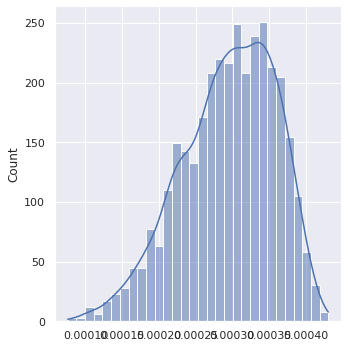

<Figure size 432x288 with 0 Axes>

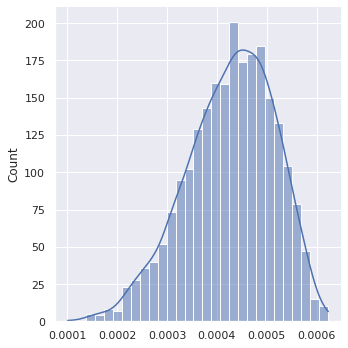

<Figure size 432x288 with 0 Axes>

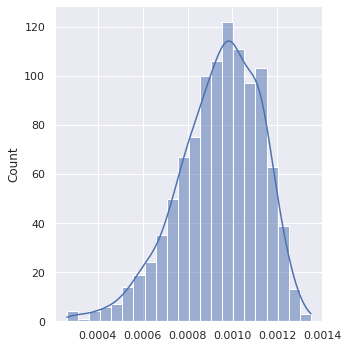

<Figure size 432x288 with 0 Axes>

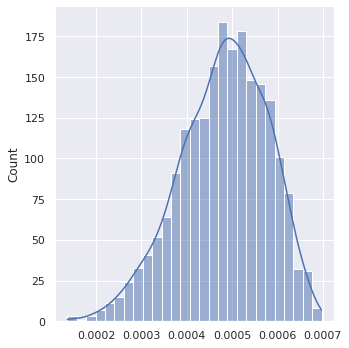

In [ ]:
model = SentenceTransformer('r2d2/stsb-bertweet-base-v0')

st = time.time()

for k in range(len(hash_list)):  
  # Compute BERTweet embedding
  bertweet_embedding = model.encode(hash_list[k])
  
  # Compute the similarity between tweets
  similarity_matrix_cosine = cosine_similarity(bertweet_embedding)

  # Build the graph of tweets
  graph = np.zeros((len(hash_list[k]), len(hash_list[k])))
  for i in range(len(hash_list[k])):
    for j in range(len(hash_list[k])):
      graph[i][j] = similarity_matrix_cosine[i][j]
  nx_graph_bertweet = nx.from_numpy_array(graph)

  # Apply pagerank and save scores
  scores_bertweet = nx.pagerank(nx_graph_bertweet)
  # Take top-4 scores (i.e. top-4 tweets)
  top_sentence_bertweet = {sentence:scores_bertweet[index] for index, sentence in enumerate(hash_list[k])}
  top_bertweet = dict(sorted(top_sentence_bertweet.items(), key = lambda x: x[1], reverse = True)[:4])
  print(str(k) + ':' )
  for sent in top_sentence_bertweet:
    if sent in top_bertweet.keys():
      print(sent)
  print('\n')
  plt.figure()
  sns.set(color_codes = True)
  x = list(scores_bertweet.values())
  sns.displot(x, kde = True)

  # Order results and print the mean between top-4 scores
  res = list(scores_bertweet.values())
  res.sort(reverse = True)
  print('Mean scores for hashtag ' + str(k) + ': ' + str(np.mean(res[:4])))

et = time.time()

print('Execution time: ', str(et - st), 'seconds')